# Initial Setup
Loading and preparing data.

In [1]:
import os
import pandas as pd

# Image root directories.
train_dir = '../input/train/train/'
test_dir = '../input/test/test/'

# Read in training CSV.
train_df = pd.read_csv('../input/train.csv')

# Create test DF by hand based on the contents.
test_images = os.listdir(test_dir)
test_df = pd.DataFrame(
    list(zip(test_images, [0] * len(test_images))),
    columns=['id', 'has_cactus']
)

# TEMP
#train_df = train_df[:100]
#test_df = test_df[:100]

# Data Preparation
Split the data and set it up for training and validation generators.

In [2]:
from sklearn.model_selection import train_test_split

# Split out the dataframe like usual (but this time with the filepaths and labels rather than raw data).
X = train_df.id
y = train_df.has_cactus
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Recombine the dataframes for use in the generators.
train_gen_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
valid_gen_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

# Create Generators
Create the generators for training and validation to be passed to the model.

In [3]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    vertical_flip=True
)
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_gen_df,
    directory=train_dir,
    x_col='id',
    y_col='has_cactus',
    class_mode='other',
    batch_size=batch_size,
    target_size=(32, 32)
)

valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)
valid_gen = valid_datagen.flow_from_dataframe(
    dataframe=valid_gen_df,
    directory=train_dir,
    x_col='id',
    y_col='has_cactus',
    class_mode='other',
    batch_size=batch_size,
    target_size=(32, 32)
)

Using TensorFlow backend.


Found 14000 validated image filenames.
Found 3500 validated image filenames.


# Build Model
Build the actual model.

In [4]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout, Flatten, Dense

input_shape = (32, 32, 3)

model = Sequential()
model.add(Conv2D(8, (3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#
model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.4))
#
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
#
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
The actual training from the generators.

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit_generator(
    train_gen,
    validation_data=valid_gen,
    validation_steps=len(train_gen),
    steps_per_epoch=len(train_gen_df) / batch_size, # bug fix
    epochs=100,
    verbose=True,
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/100
219/218 [==============================] - 24s 108ms/step - loss: 0.1480 - acc: 0.9453 - val_loss: 0.0897 - val_acc: 0.9660
Epoch 2/100
219/218 [==============================] - 13s 59ms/step - loss: 0.0626 - acc: 0.9789 - val_loss: 0.0494 - val_acc: 0.9825
Epoch 3/100
219/218 [==============================] - 13s 60ms/step - loss: 0.0526 - acc: 0.9817 - val_loss: 0.8328 - val_acc: 0.8505
Epoch 4/100
219/218 [==============================] - 13s 60ms/step - loss: 0.0386 - acc: 0.9869 - val_loss: 0.0754 - val_acc: 0.9699
Epoch 5/100
219/218 [==============================] - 13s 59ms/step - loss: 0.0300 - acc: 0.9900 - val_loss: 0.1712 - val_acc: 0.9337
Epoch 6/100
219/218 [==============================] - 13s 59ms/step - loss: 0.0249 - acc: 0.9922 - val_loss: 0.0263 - val_acc: 0.9917
Epoch 7/100
219/218 [==============================] - 13s 59ms/step - loss: 0.0247 - acc: 0.9919 - val_loss: 0.0233 - val_acc: 0.9930
Epoch 8/100
219/218 [==============================] -

# Model Results

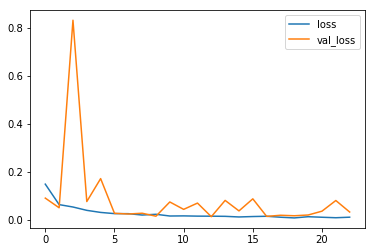

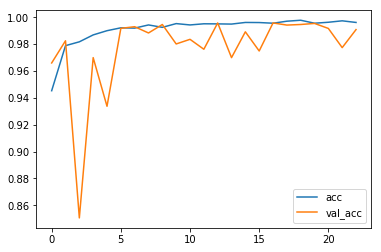

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# Process Test Data
Prepare the test data for prediction.

In [7]:
model.load_weights('model.h5')

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)
test_gen = valid_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    class_mode=None,
    batch_size=1,
    target_size=(32, 32),
    shuffle=False
)

Found 4000 validated image filenames.


# Predict!

In [8]:
predictions = model.predict_generator(test_gen, steps=len(test_gen), verbose=True)
#predictions_binary = [0 if x < 0.5 else 1 for x in predictions]

4000/4000 [==============================] - 8s 2ms/step


In [9]:
test_df['has_cactus'] = predictions
test_df.to_csv('submission.csv', index=False)
print('Done!')

Done!


In [10]:
test_df

,id,has_cactus
0,6a571b6df250e9575fb82f8904c325a1.jpg,1.000000e+00
1,2edb0bf826248b088d57e22799464c41.jpg,9.999844e-01
2,ea9422f63363a362ba6f482617006e76.jpg,1.000000e+00
3,1021509e308bf12f71a01cac2ddca97f.jpg,9.999982e-01
4,5eacbb413e5cd4e73cb7b1936758abf1.jpg,9.999998e-01
5,861dccb4950b74108760daae0a1e016b.jpg,9.999999e-01
6,6472fab8708bcd522836a9f1c6e9aae6.jpg,0.000000e+00
7,3a77f9113b60c62b7d30c5f41828ab6b.jpg,1.000000e+00
8,305d9cefe442e30abae64d84ecc8340e.jpg,1.000000e+00
9,71957d3a60ca371e441fb6ff5ee6379f.jpg,5.456326e-03
